# Domain-Adversarial Training of Neural Networks (DANN)



In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import RandomSampler,Dataset,DataLoader

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import shutil
import os
from torch.utils import data

## Tool Functions

In [2]:
def adjust_learning_rate(optimizer,epoch):
    lr=0.001*0.1**(epoch//10)
    for param_group in optimizer.param_groups:
        param_group['lr']=lr
    return lr

def accuracy(output,target,topk=(1,)):
    maxk=max(topk)
    batch_size=target.size(0)
    _,pred=output.topk(maxk,1,True,True)
    pred=pred.t()
    correct=pred.eq(target.view(1,-1).expand_as(pred))
    res=[]
    for k in topk:
        correct_k=correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100/batch_size))
    return res

def matplotlib_imshow(img,one_channel=False):
    if one_channel:
        img=img.mean(dim=0)
    np_img=img.numpy()
    np_img=(np_img-np.min(np_img))/(np.max(np_img)-np.min(np_img))
    if one_channel:
        plt.imshow(np_img,cmap="Greys")
    else:
        plt.imshow(np.transpose(np_img,(1,2,0)))

class ColoredMNIST(Dataset):
    def __init__(self, file_name):
        self.data_label = torch.load(file_name)
        # self.data_label=transforms.ToTensor()(self.data_label)

    def __getitem__(self, index):
        img, target = self.data_label[index]
        img = transforms.ToTensor()(img)
        return img, target

    def __len__(self):
        return len(self.data_label)

    def __add__(self,other):
        pass

class AverageMeter(object):
    def __init__(self):
        self.reset()
    def reset(self):
        self.val=0
        self.avg=0
        self.sum=0
        self.count=0
    def update(self,val,n=1):
        self.val=val
        self.sum+=val*n
        self.count+=n
        self.avg=self.sum/self.count

## Tensorboard

In [3]:
log_dir="minist_experiment_1"
remove_log_dir=True
if remove_log_dir and os.path.exists(log_dir):
    shutil.rmtree(log_dir)

## Loading Data

In [4]:
image_size=28
batch_size=32

transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.ToTensor(),
                               transforms.Normalize(mean=[0.5],std=[0.5])])
train_ds = ColoredMNIST('./dataset/ColoredMNIST/train1.pt') # source domain training datasets
train_dl = data.DataLoader(dataset=train_ds,batch_size=batch_size,shuffle=True)
test_ds = ColoredMNIST('./dataset/ColoredMNIST/train2.pt') # source domain testing datasets
test_dl = data.DataLoader(dataset=test_ds,batch_size=batch_size,shuffle=False)
train_m_ds = ColoredMNIST('./dataset/ColoredMNIST/test.pt') # target domain training datasets
train_m_dl = data.DataLoader(dataset=train_m_ds,batch_size=batch_size,shuffle=True)
test_m_ds = ColoredMNIST('./dataset/ColoredMNIST/test.pt') # target domain testing datasets
test_m_dl = data.DataLoader(dataset=test_m_ds,batch_size=batch_size,shuffle=False)


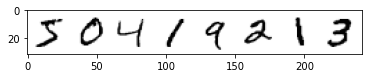

In [5]:
%matplotlib inline

writer=SummaryWriter(log_dir)
show_images=[train_ds[i][0] for i in range(8)]
show_labels=[train_ds[i][1] for i in range(8)]
show_img_grid=make_grid(show_images)
matplotlib_imshow(show_img_grid,one_channel=True)
writer.add_image("mnist_images",show_img_grid)

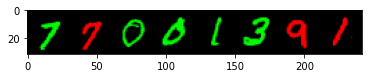

In [6]:
show_images=[train_m_ds[i][0] for i in range(8)]
show_labels=[train_m_ds[i][1] for i in range(8)]
show_img_grid=make_grid(show_images)
matplotlib_imshow(show_img_grid,one_channel=False)
writer.add_image("mnist_m_images",show_img_grid)

## Source-Only Training

在源域上独立训练CNN模型

In [7]:
class CNN(nn.Module):
    def __init__(self,num_classes=10):
        super(CNN,self).__init__()
        self.features=nn.Sequential(
            nn.Conv2d(3,32,5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32,48,5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.avgpool=nn.AdaptiveAvgPool2d((5,5))
        self.classifier=nn.Sequential(
            nn.Linear(48*5*5,100),
            nn.ReLU(inplace=True),
            nn.Linear(100,100),
            nn.ReLU(inplace=True),
            nn.Linear(100,num_classes)
        )
    def forward(self,x):
        x=x.expand(x.data.shape[0],3,image_size,image_size)
        x=self.features(x)
        x=self.avgpool(x)
        x=torch.flatten(x,1)
        x=self.classifier(x)
        return x

用一个5层的神经网络在mnist上使用Adam训练，准确率约为73%(考虑到理想的最高正确率为75%，这里CNN的表现已经足够)

In [8]:
cnn_model=CNN()
optimizer=Adam(cnn_model.parameters(),lr=0.001)
Loss=nn.CrossEntropyLoss()
epochs=5
train_loss=AverageMeter()
test_loss=AverageMeter()
test_top1=AverageMeter()
train_top1=AverageMeter()
train_cnt=AverageMeter()
print_freq=100
# cnn_model.cuda()
for epoch in range(epochs):
    lr=adjust_learning_rate(optimizer,epoch)
    writer.add_scalar("lr",lr,epoch)
    train_loss.reset()
    train_top1.reset()
    train_cnt.reset()
    test_top1.reset()
    test_loss.reset()
    for images,labels in tqdm(train_dl):
        # images=images.cuda()
        # labels=labels.cuda()
        optimizer.zero_grad()
        predict=cnn_model(images)
        losses=Loss(predict,labels)
        train_loss.update(losses.data,images.size(0))
        top1=accuracy(predict.data,labels,topk=(1,))[0]
        train_top1.update(top1,images.size(0))
        train_cnt.update(images.size(0),1)
        losses.backward()
        optimizer.step()
        if train_cnt.count%print_freq==0:
            print("Epoch:{}[{}/{}],Loss:[{:.3f},{:.3f}],prec[{:.4f},{:.4f}]".format(epoch,train_cnt.count,len(train_dl),train_loss.val,train_loss.avg,
                                                            train_top1.val,train_top1.avg))
    for images,labels in tqdm(test_dl):
        # images=images.cuda()
        # labels=labels.cuda()
        predict=cnn_model(images)
        losses=Loss(predict,labels)
        test_loss.update(losses.data,images.size(0))
        top1=accuracy(predict.data,labels,topk=(1,))[0]
        test_top1.update(top1,images.size(0))
    print("Epoch:{},val,Loss:[{:.3f}],prec[{:.4f}]".format(epoch,test_loss.avg,test_top1.avg))
    writer.add_scalar("train_loss",train_loss.avg,epoch)
    writer.add_scalar("test_loss",test_loss.avg,epoch)
    writer.add_scalar("train_top1",train_top1.avg,epoch)
    writer.add_scalar("test_top1",test_top1.avg,epoch)

  0%|          | 0/625 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2688x28 and 2352x128)

## Direct Transferring

直接用mnist数据集训练的网络识别ColoredMNIST数据集，准确率约为72.3%.可以看作领域适应方法准确率的上界。

In [ ]:
test_m_top1=AverageMeter()
test_m_loss=AverageMeter()
for images,labels in tqdm(test_m_dl):
    # images=images.cuda()
    # labels=labels.cuda()
    predict=cnn_model(images)
    losses=Loss(predict,labels)
    test_m_loss.update(losses.data,images.size(0))
    top1=accuracy(predict.data,labels,topk=(1,))[0]
    test_m_top1.update(top1,images.size(0))
print("Epoch:{},val,Loss:[{:.3f}],prec[{:.4f}]".format(epoch,test_m_loss.avg,test_m_top1.avg))

## Direct Training

直接使用ColoredMNIST训练，准确率约为30.3050%，可以看坐领域适应方法准确率的下界。

In [ ]:
train_loss=AverageMeter()
test_loss=AverageMeter()
test_top1=AverageMeter()
train_top1=AverageMeter()
train_cnt=AverageMeter()
print_freq=200
# cnn_model.cuda()
epochs=5
for epoch in range(epochs):
    lr=adjust_learning_rate(optimizer,epoch)
    writer.add_scalar("lr",lr,epoch)
    train_loss.reset()
    train_top1.reset()
    train_cnt.reset()
    test_top1.reset()
    test_loss.reset()
    for images,labels in tqdm(train_m_dl):
        # images=images.cuda()
        # labels=labels.cuda()
        optimizer.zero_grad()
        predict=cnn_model(images)
        losses=Loss(predict,labels)
        train_loss.update(losses.data,images.size(0))
        top1=accuracy(predict.data,labels,topk=(1,))[0]
        train_top1.update(top1,images.size(0))
        train_cnt.update(images.size(0),1)
        losses.backward()
        optimizer.step()
        if train_cnt.count%print_freq==0:
            print("Epoch:{}[{}/{}],Loss:[{:.3f},{:.3f}],prec[{:.4f},{:.4f}]".format(epoch,train_cnt.count,len(train_dl),train_loss.val,train_loss.avg,
                                                                   train_top1.val,train_top1.avg))
    for images,labels in tqdm(test_m_dl):
        # images=images.cuda()
        # labels=labels.cuda()
        predict=cnn_model(images)
        losses=Loss(predict,labels)
        test_loss.update(losses.data,images.size(0))
        top1=accuracy(predict.data,labels,topk=(1,))[0]
        test_top1.update(top1,images.size(0))
    print("Epoch:{},val,Loss:[{:.3f}],prec[{:.4f}]".format(epoch,test_loss.avg,test_top1.avg))
    writer.add_scalar("train_loss",train_loss.avg,epoch)
    writer.add_scalar("test_loss",test_loss.avg,epoch)    
    writer.add_scalar("train_top1",train_top1.avg,epoch)
    writer.add_scalar("test_top1",test_top1.avg,epoch)

## Gradient Reverse Layer (GRL)

梯度反转层，这一层正向表现为恒等变换，反向传播是改变梯度的符号，alpha用来平衡域损失的权重。

In [ ]:
from torch.autograd import Function

class GRL(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None

## DANN

In [ ]:
class DANN(nn.Module):
    def __init__(self,num_classes=10):
        super(DANN,self).__init__()
        self.features=nn.Sequential(
            nn.Conv2d(3,32,5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32,48,5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.avgpool=nn.AdaptiveAvgPool2d((5,5))
        self.task_classifier=nn.Sequential(
            nn.Linear(48*5*5,100),
            nn.ReLU(inplace=True),
            nn.Linear(100,100),
            nn.ReLU(inplace=True),
            nn.Linear(100,num_classes)
        )
        self.domain_classifier=nn.Sequential(
            nn.Linear(48*5*5,100),
            nn.ReLU(inplace=True),
            nn.Linear(100,2)
        )
        self.GRL=GRL()
    def forward(self,x,alpha):
        x = x.expand(x.data.shape[0], 3, image_size,image_size)
        x=self.features(x)
        x=self.avgpool(x)
        x=torch.flatten(x,1)
        task_predict=self.task_classifier(x)
        x=GRL.apply(x,alpha)
        domain_predict=self.domain_classifier(x)
        return task_predict,domain_predict

## Domain Transfer Training

使用DANN进行领域迁移训练，使用mnist上的有标签数据和ColoredMNIST上的无标签数据，准确率约为50.41%.

In [ ]:
train_loss=AverageMeter()
train_domain_loss=AverageMeter()
train_task_loss=AverageMeter()
test_loss=AverageMeter()
test_top1=AverageMeter()
test_domain_acc=AverageMeter()
train_top1=AverageMeter()
train_cnt=AverageMeter()

print_freq=200
domain_model=DANN()
# domain_model.cuda()
domain_loss=nn.CrossEntropyLoss()
task_loss=nn.CrossEntropyLoss()
lr=0.001
optimizer=Adam(domain_model.parameters(),lr=lr)
epochs=100
states=[]

for epoch in range(epochs):

    #lr=adjust_learning_rate(optimizer,epoch)
    writer.add_scalar("lr",lr,epoch)
    train_loss.reset()
    train_domain_loss.reset()
    train_task_loss.reset()
    train_top1.reset()
    train_cnt.reset()
    test_top1.reset()
    test_loss.reset()
    for source,target in zip(train_dl,train_m_dl):
        train_cnt.update(images.size(0),1)
        p = float(train_cnt.count + epoch * len(train_dl)) / (epochs *len(train_dl))
        alpha = torch.tensor(2. / (1. + np.exp(-10 * p)) - 1)
        src_imgs=source[0]
        src_labels=source[1]
        dst_imgs=target[0]
        optimizer.zero_grad()
        
        src_predict,src_domains=domain_model(src_imgs,alpha)
        src_label_loss=task_loss(src_predict,src_labels)
        src_domain_loss=domain_loss(src_domains,torch.ones(len(src_domains)).long())
        
        _,dst_domains=domain_model(dst_imgs,alpha)
        dst_domain_loss=domain_loss(dst_domains,torch.zeros(len(dst_domains)).long())
        
        losses=src_label_loss+src_domain_loss+dst_domain_loss
        
        train_loss.update(losses.data,images.size(0))
        train_domain_loss.update(dst_domain_loss.data,images.size(0))
        train_task_loss.update(src_label_loss.data,images.size(0))
        top1=accuracy(src_predict.data,src_labels,topk=(1,))[0]
        train_top1.update(top1,images.size(0))
        
        losses.backward()
        optimizer.step()
        if train_cnt.count%print_freq==0:
            print("Epoch:{}[{}/{}],Loss:[{:.3f},{:.3f}],domain loss:[{:.3f},{:.3f}],label loss:[{:.3f},{:.3f}],prec[{:.4f},{:.4f}],alpha:{}".format(
                epoch,train_cnt.count,len(train_dl),train_loss.val,train_loss.avg,
                train_domain_loss.val,train_domain_loss.avg,
                train_task_loss.val,train_task_loss.avg,train_top1.val,train_top1.avg,alpha))
    for images,labels in tqdm(test_m_dl):
        # images=images.cuda()
        # labels=labels.cuda()
        predicts,domains=domain_model(images,0)
        losses=task_loss(predicts,labels)
        test_loss.update(losses.data,images.size(0))
        top1=accuracy(predicts.data,labels,topk=(1,))[0]
        domain_acc=accuracy(domains.data,torch.zeros(len(domains)).long(),topk=(1,))[0]
        test_top1.update(top1,images.size(0))
        test_domain_acc.update(domain_acc,images.size(0))
    print("Epoch:{},val,Loss:[{:.3f}],prec[{:.4f}],domain_acc[{:.4f}]".format(epoch,test_loss.avg,test_top1.avg,test_domain_acc.avg))
    states.append([test_loss.avg.item(), test_top1.avg.item(),test_domain_acc.avg.item()])
    writer.add_scalar("train_loss",train_loss.avg,epoch)
    writer.add_scalar("test_loss",test_loss.avg,epoch)    
    writer.add_scalar("train_top1",train_top1.avg,epoch)
    writer.add_scalar("test_top1",test_top1.avg,epoch)
    writer.add_scalar("test_domain",test_domain_acc.avg,epoch)

## Learning States Plot

In [ ]:
steps = np.linspace(0, 100, 100)
states = np.array(states)

plt.figure()
# plt.plot(steps, states[:, 0], c='blue', label='Loss')
plt.plot(steps, states[:, 1], label='Precision')
plt.plot(steps, states[:,2], label='Domain Accuracy')
plt.xlabel('Epoch')
plt.title('DANN2 Performance on ColoredMNIST')
plt.legend()
plt.show()
print(states)

In [ ]:
plt.figure()
plt.plot(steps, states[:, 0],  label='Loss')
plt.xlabel('Epoch')
plt.title('DANN Loss Performance on ColoredMNIST')
plt.legend()
plt.show()